# Fine-tune BERT for sentiment analysis

1. text preprocessing (tokenization, padding, and attention masks) 
2. Use Transfer Learning to build Sentiment Classifier using the Transformers library by Hugging Face
3. Evaluate the model on test data
4. Predict sentiment on raw text

In [1]:
!nvidia-smi

Wed Dec 29 23:41:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 5.4 MB/s 
     |████████████████████████████████| 3.3 MB 24.4 MB/s 
     |████████████████████████████████| 895 kB 3.6 MB/s 
     |████████████████████████████████| 61 kB 274 kB/s 
     |████████████████████████████████| 596 kB 10.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

!ls '/content/drive'

Mounted at /content/drive/
MyDrive  Shareddrives


In [5]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/reviews.csv", parse_dates = ['at', 'repliedAt'])
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


# 1. EDA

In [6]:
df.shape

(15746, 11)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   userName              15746 non-null  object        
 1   userImage             15746 non-null  object        
 2   content               15746 non-null  object        
 3   score                 15746 non-null  int64         
 4   thumbsUpCount         15746 non-null  int64         
 5   reviewCreatedVersion  13533 non-null  object        
 6   at                    15746 non-null  datetime64[ns]
 7   replyContent          7367 non-null   object        
 8   repliedAt             7367 non-null   datetime64[ns]
 9   sortOrder             15746 non-null  object        
 10  appId                 15746 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 1.3+ MB


Text(0.5, 0, 'review score')

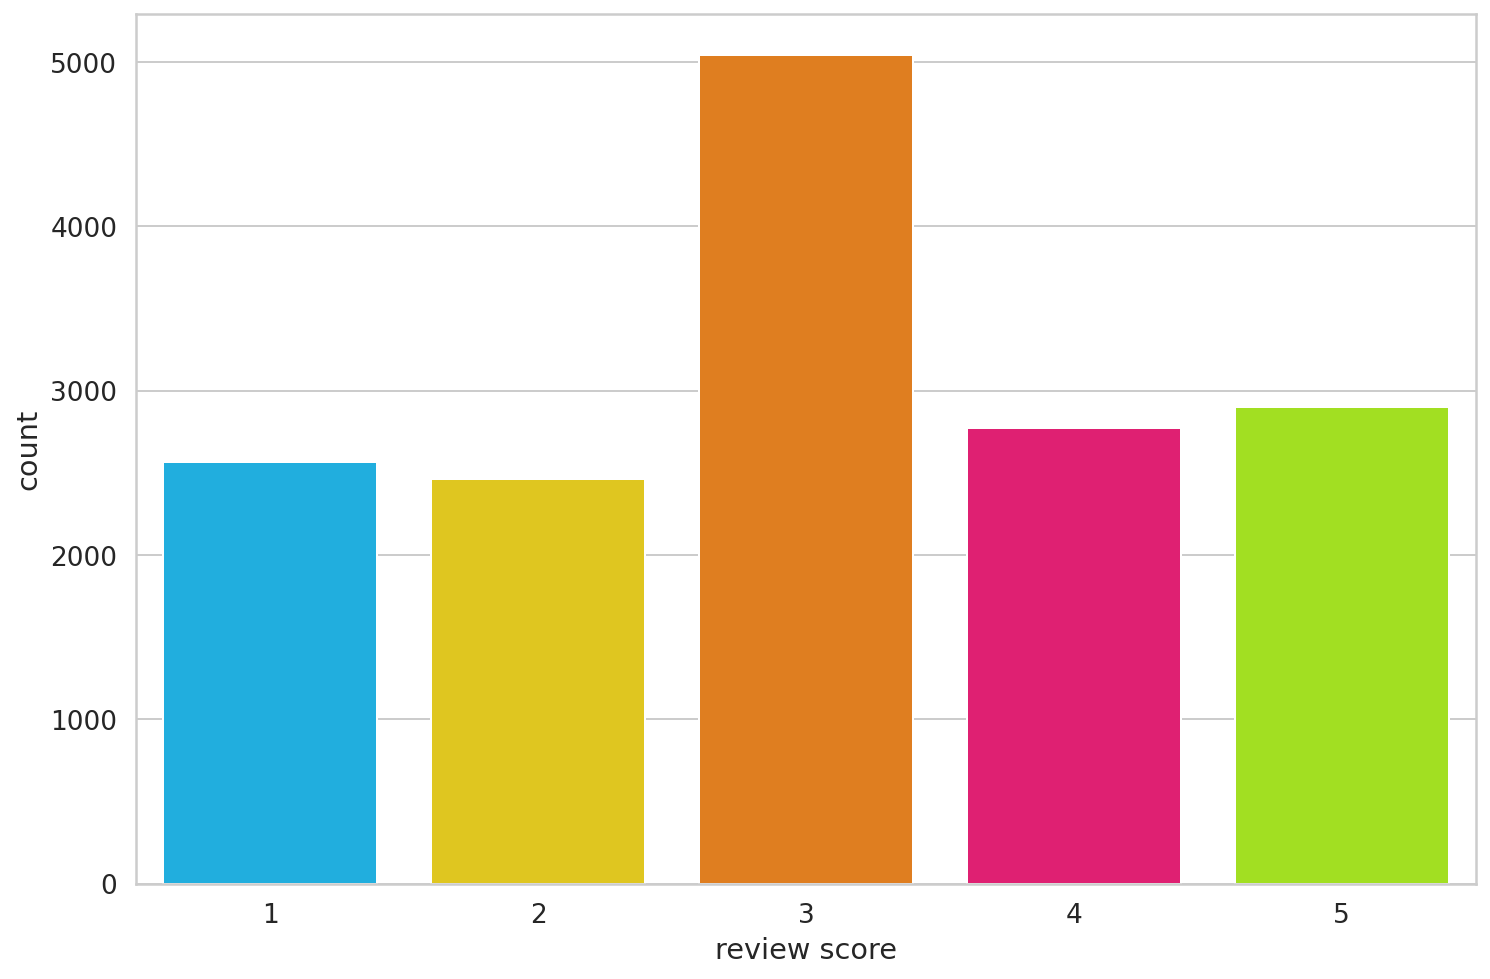

In [8]:
sns.countplot(data=df, x='score')
plt.xlabel('review score')

In [9]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else: 
        return 2

df['sentiment'] = df.score.apply(to_sentiment)

[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

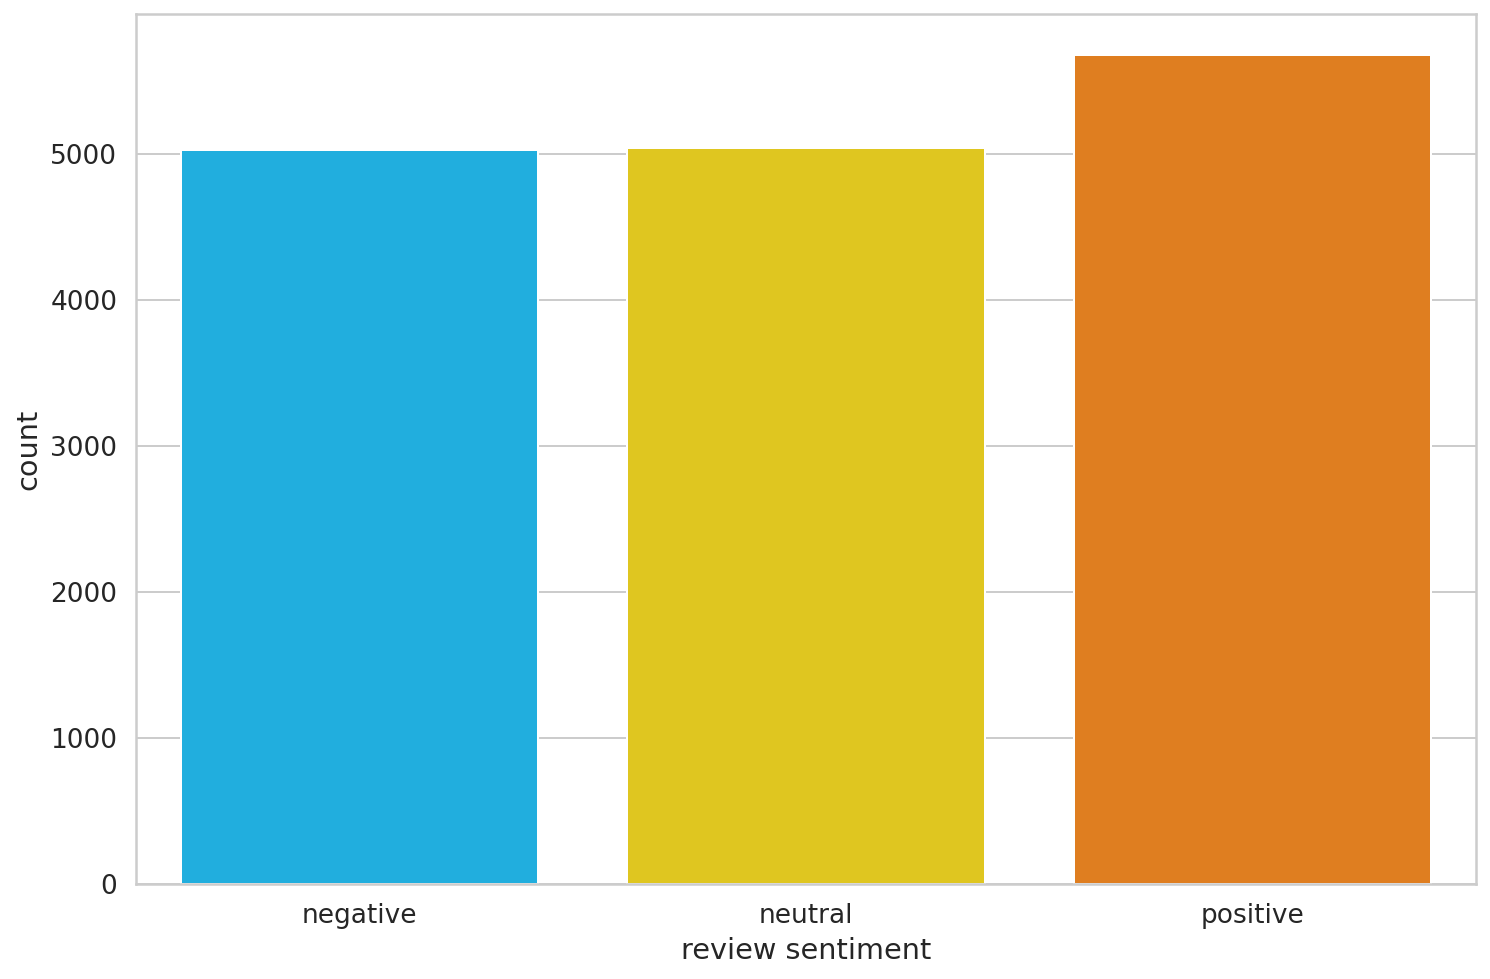

In [10]:
class_names = ['negative', 'neutral', 'positive']

ax = sns.countplot(data=df, x='sentiment')
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

In [11]:
# input
df.content.to_numpy()

array(["Update: After getting a response from the developer I would change my rating to 0 stars if possible. These guys hide behind confusing and opaque terms and refuse to budge at all. I'm so annoyed that my money has been lost to them! Really terrible customer experience. Original: Be very careful when signing up for a free trial of this app. If you happen to go over they automatically charge you for a full years subscription and refuse to refund. Terrible customer experience and the app is just OK.",
       'Used it for a fair amount of time without any problems. Suddenly then asked me to create an account or log using Google or FB. I used my Google one only to discover everything was gone!',
       "Your app sucks now!!!!! Used to be good but now doesn't update until I physically open it up and then close it then scroll and then it finally shows what I want to put on the list!!!!!! And I FRIGGEN paid for this garbage!!!!!!!",
       ..., 'Works well for what I need', 'Love it.',
 

In [12]:
# target
df.sentiment.to_numpy()

array([0, 0, 0, ..., 2, 2, 2])

# 2. Data Preprocessing for Bert

- Tokenization, including add special tokens to separate sentences
- Create attention mask (array of 0, which is pad token, and 1, which is real token)
- Pass sequences of constant length (introduce padding)
- Create Dataset and DataLoader

### demo:

In [13]:
# text would not be lowercased before tokenization
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# token for padding
print(tokenizer.pad_token, tokenizer.pad_token_id)

# token not in training set
print(tokenizer.unk_token, tokenizer.unk_token_id)

# [CLS] - we must add this token to the start of each sentence, so BERT knows we're doing classification
print(tokenizer.cls_token, tokenizer.cls_token_id)

# [SEP] - marker for ending of a sentence
print(tokenizer.sep_token, tokenizer.sep_token_id)
print('=======================')


sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')
print('=======================')


encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  truncation=True, # Truncate to a maximum length specified with the argument max_length
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

# length of first sentence = 32 <max_length>
print(encoding['input_ids'][0])
print('flatten: ', encoding['input_ids'][0].flatten())
print('length of 1st encoding: ', len(encoding['input_ids'][0]))

print(encoding['attention_mask'][0])
print('length of 1st attention_mask: ', len(encoding['attention_mask'][0]))

tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

[PAD] 0
[UNK] 100
[CLS] 101
[SEP] 102
 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]
tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
flatten:  tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
length of 1st encoding:  32
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
length of 1st attention_mask:  32


['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

## Choosing Sequence Length 

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length.

In [14]:
# text would not be lowercased before tokenization
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

token_lens = []

for txt in df.content:
    tokens = tokenizer.encode(txt, max_length = 512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


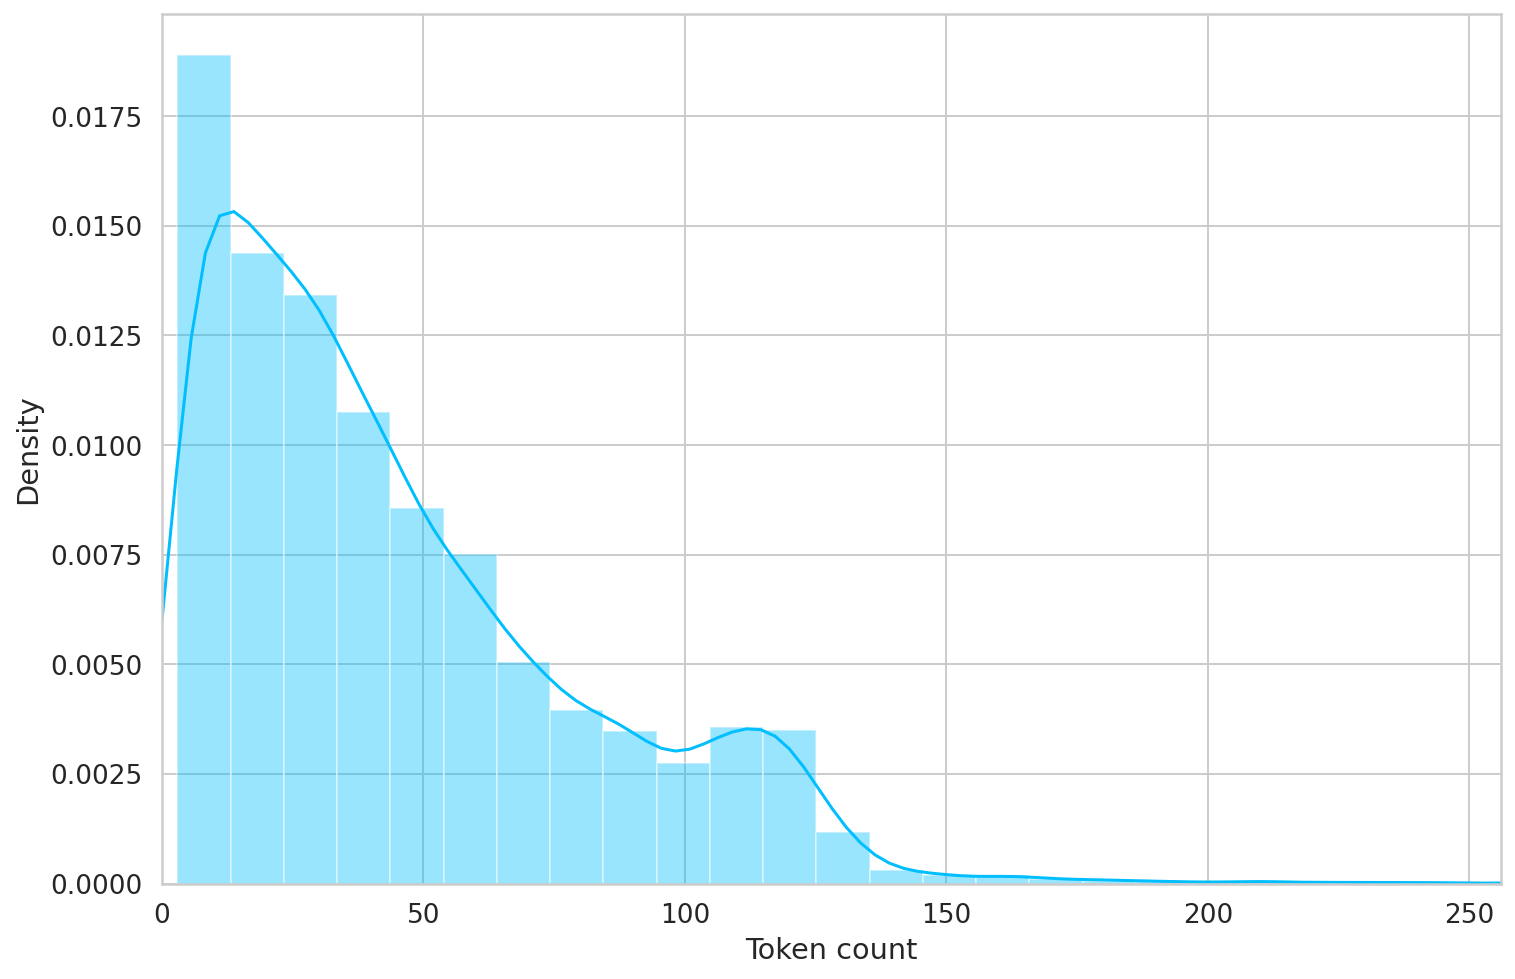

In [15]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [16]:
# Most of the reviews seem to contain less than 128 tokens, but on the safe side and choose a maximum length of 160.
MAX_LEN = 160

## Build PyTorch dataset

Customized dataset class inherets from torch.utils.data.Dataset class, overide \_\_init\_\_, \_\_len\_\_ (return data size), \_\_getitem\_\_ (return item from given index)

In [17]:
class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(review,
                                              add_special_tokens = True,
                                              max_length = self.max_len,
                                              return_token_type_ids = False,
                                              truncation = True,
                                              padding = 'max_length',
                                              return_attention_mask=True,
                                              return_tensors = 'pt')
        return {'review_text': review,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'targets': torch.tensor(target, dtype=torch.long)}

## Build PyTorch dataloader

Dataloader fetches data from a Dataset and serves the data up in batches, which can be used in stochastic gradient descent.

In [18]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    dataset = GPReviewDataset(reviews = df.content.to_numpy(),
                              targets = df.sentiment.to_numpy(),
                              tokenizer = tokenizer,
                              max_len = max_len)

    return DataLoader(dataset, 
                      batch_size = batch_size, 
                      num_workers = 2)

In [19]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)
df_train.head(5)

(14171, 12) (787, 12) (788, 12)


,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
1562,Raspiy,https://lh3.googleusercontent.com/a-/AOh14Ghrh...,You can't have your to do list as notifications,2,0,14.4.5,2019-09-21 15:53:02,Thank you for your feedback. Please consider u...,2019-09-25 15:28:49,newest,com.todoist,0
15084,Ebony Sealey,https://lh3.googleusercontent.com/a-/AOh14GhtS...,I haven't been using this very long and it's n...,3,0,3.2.1,2016-01-04 15:00:00,NaN,NaT,most_relevant,com.appxy.planner,1
7417,Iindin the Edresia,https://lh3.googleusercontent.com/a-/AOh14GgPK...,1. Кривой и неработающий экспорт и импорт. 2. ...,3,5,2.20.0,2019-12-17 07:23:14,Спасибо за ваш отзыв. Я уже исправил часть нед...,2019-11-29 12:56:14,most_relevant,com.levor.liferpgtasks,1
12044,Hydee Fisher,https://lh3.googleusercontent.com/a-/AOh14Gi5u...,Love it so far. Wish it had a widget for Andro...,3,0,NaN,2019-09-15 14:16:45,Hi Hydee! Thanks for your feedback! A widget i...,2020-01-27 18:34:43,most_relevant,com.artfulagenda.app,1
12410,Tanya Ruppell,https://lh3.googleusercontent.com/-WBTnuwk7Aas...,Liked the prioritization by dragging and the h...,2,1,1.21,2018-11-10 12:46:07,"Hi Tanya, to add a recurring task simply add a...",2018-11-10 13:52:09,most_relevant,com.tasks.android,0


In [20]:
# increasing the batch size reduces the training time significantly, but gives you lower accuracy.
BATCH_SIZE = 16
MAX_LEN = 160

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [21]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [22]:
print(data['review_text'])
print(data['input_ids'].shape) # (batch_size, max_token_len)
print(data['attention_mask'].shape) # (batch_size, max_token_len)
print(data['targets'].shape) # (batch_size)

["You can't have your to do list as notifications", "I haven't been using this very long and it's not as user friendly as the Calender that came on my last phone.  I wish instead of dots you can just see what you have entered for that day immediately without tapping on that day.  Otherwise it is easy to use and functional.", '1. Кривой и неработающий экспорт и импорт. 2. Нельзя удалить базовые навыки, заданий и характеристики. 3. Нельзя удалять сразу несколько навыков, заданий и характеристик. 4. Кнопка отчислить данные не удаляет всё, а только откатывает к базовым. Спустя пару месяцев снова установил приложение. Загрузил с автосохронерия данных - загрузилось всё базовое и с диска тоже самое (настройки тоже). Проверял после установки изменяя данные и сохраняя их потом. Итог: после загрузки зброс к базовым.', 'Love it so far. Wish it had a widget for Android though.', "Liked the prioritization by dragging and the highlighting, but there does not seem to be a way to create recurring task

# 3. Sentiment Classification with BERT and Hugging Face

### demo

In [23]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) # 'bert-base-cased'

# encoding: 'When was I last outside? I am stuck at home for 2 weeks.'
last_hidden_state, pooled_output = bert_model(
    input_ids = encoding['input_ids'], 
    attention_mask = encoding['attention_mask'],
    return_dict = False
  )

# The last_hidden_state is a sequence of hidden states of the last layer of the model. 
# last_hidden_state = output_with_pooling_and_cross_attentions[0]
# pooled_output = output_with_pooling_and_cross_attentions[1]

# The last_hidden_state is a sequence of hidden states of the last layer of the model. 
print(last_hidden_state.shape) # (batch_size, max_token_len, embedding_dim)

# summary of the content, the embedding of the [CLS] special token
print(pooled_output.shape)

# configured dimension of embedding (# of hidden units in the feedforward-networks)
print(bert_model.config.hidden_size)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([1, 32, 768])
torch.Size([1, 768])
768


## Build Sentiment Classifier from pre-trained BERT

The pre-trained model is trained on a large corpus in an unsupervised manner, hence the model learns the generic representations of the tokens from a large corpus of text. 

This makes it easy to later fine-tune it for any other NLP task, as the model comes pre-trained with large context about the language, grammar and semantic representations.

In [24]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) 
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, pooled_output = self.bert(
                    input_ids = input_ids, 
                    attention_mask = attention_mask,
                    return_dict = False)

        # dropout layer for regularization
        output = self.drop(pooled_output)

        # fully-connected layer for our output, return output for following cross-entropy loss function
        # no need to do softmax, as to nn.CrossEntropyLoss, the input is expected to contain raw, unnormalized scores for each class. 
        return self.out(output)

### demo

In [25]:
model = SentimentClassifier(len(class_names)) # class_names: ['negative', 'neutral', 'positive']
model = model.to(device)

input_ids = data['input_ids'].to(device) # data is one batch of samples
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

F.softmax(model(input_ids, attention_mask), dim=1)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([16, 160])
torch.Size([16, 160])


tensor([[0.2332, 0.4717, 0.2951],
        [0.2219, 0.3612, 0.4168],
        [0.3589, 0.2427, 0.3984],
        [0.2221, 0.3218, 0.4561],
        [0.5762, 0.2056, 0.2181],
        [0.2249, 0.4422, 0.3329],
        [0.2750, 0.3181, 0.4069],
        [0.3732, 0.2454, 0.3813],
        [0.3927, 0.1892, 0.4181],
        [0.3349, 0.1948, 0.4703],
        [0.3043, 0.2263, 0.4695],
        [0.3710, 0.1894, 0.4396],
        [0.2090, 0.4449, 0.3462],
        [0.3396, 0.2594, 0.4010],
        [0.3456, 0.2260, 0.4284],
        [0.1500, 0.3302, 0.5198]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

## Traninig

AdamW optimizer is provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. 

In [26]:
# helper function for training our model for one epoch
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    # put model in traning mode, so batch_norm, dropout etc. are applied
    model = model.train()

    losses = []
    correct_predictions = 0

    # each epoch will go over the whole dataset by feeding batches multiple times
    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask)

        # confidence, predicated_class:{0,1,2}
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()

        # avoiding exploding gradients by clipping the gradients of the model
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    # return accuracy, loss
    return correct_predictions.double()/n_examples, np.mean(losses) 

In [27]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    # put model in evaluation mode, so batch_norm, dropout etc. are not applied
    model = model.eval()

    losses = []
    correct_predictions = 0

    # disable gradient so torch computation can be faster
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
              input_ids=input_ids,
              attention_mask=attention_mask)

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            # no need to update gradients and parameters in evaluation

    # return accuracy, loss    
    return correct_predictions.double() / n_examples, np.mean(losses)


In [28]:
model = SentimentClassifier(len(class_names)) # ['negative', 'neutral', 'positive']
model = model.to(device)

EPOCHS = 6

optimizer = AdamW(model.parameters(), lr = 2e-5, correct_bias = False)
total_steps = len(train_data_loader) * EPOCHS

# get_linear_schedule_with_warmup: 
# Create a schedule with a learning rate that decreases linearly from the initial lr set in the optimizer to 0, 
# after a warmup period during which it increases linearly from 0 to the initial lr set in the optimizer.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps = total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
%%time

# "default" item is created using list()
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print('Epoch ', epoch + 1, '/', EPOCHS)
    print('-' * 10)

    train_acc, train_loss = train_epoch(model,
                                        train_data_loader,
                                        loss_fn,
                                        optimizer,
                                        device,
                                        scheduler,
                                        len(df_train))
    print('Train accuracy: ', train_acc, 'loss: ', train_loss)

    val_acc, val_loss = eval_model(model,
                                   val_data_loader,
                                   loss_fn,
                                   device,
                                   len(df_val))
    print('Val accuracy: ', val_acc, 'loss: ', val_loss)
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        # save the model which has the best accuracy on validation set
        torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/best_model_state.pt')
        best_accuracy = val_acc


Epoch  1 / 6
----------
Train accuracy:  tensor(0.6891, device='cuda:0', dtype=torch.float64) loss:  0.7033827842021904
Val accuracy:  tensor(0.7586, device='cuda:0', dtype=torch.float64) loss:  0.598976861834526

Epoch  2 / 6
----------
Train accuracy:  tensor(0.8431, device='cuda:0', dtype=torch.float64) loss:  0.4176941687876094
Val accuracy:  tensor(0.8412, device='cuda:0', dtype=torch.float64) loss:  0.5368866513669491

Epoch  3 / 6
----------
Train accuracy:  tensor(0.9264, device='cuda:0', dtype=torch.float64) loss:  0.23302724381906673
Val accuracy:  tensor(0.8577, device='cuda:0', dtype=torch.float64) loss:  0.6265844308678061

Epoch  4 / 6
----------
Train accuracy:  tensor(0.9565, device='cuda:0', dtype=torch.float64) loss:  0.16066057814070198
Val accuracy:  tensor(0.8729, device='cuda:0', dtype=torch.float64) loss:  0.6941964393202216

Epoch  5 / 6
----------
Train accuracy:  tensor(0.9702, device='cuda:0', dtype=torch.float64) loss:  0.1117511474110636
Val accuracy:  tens

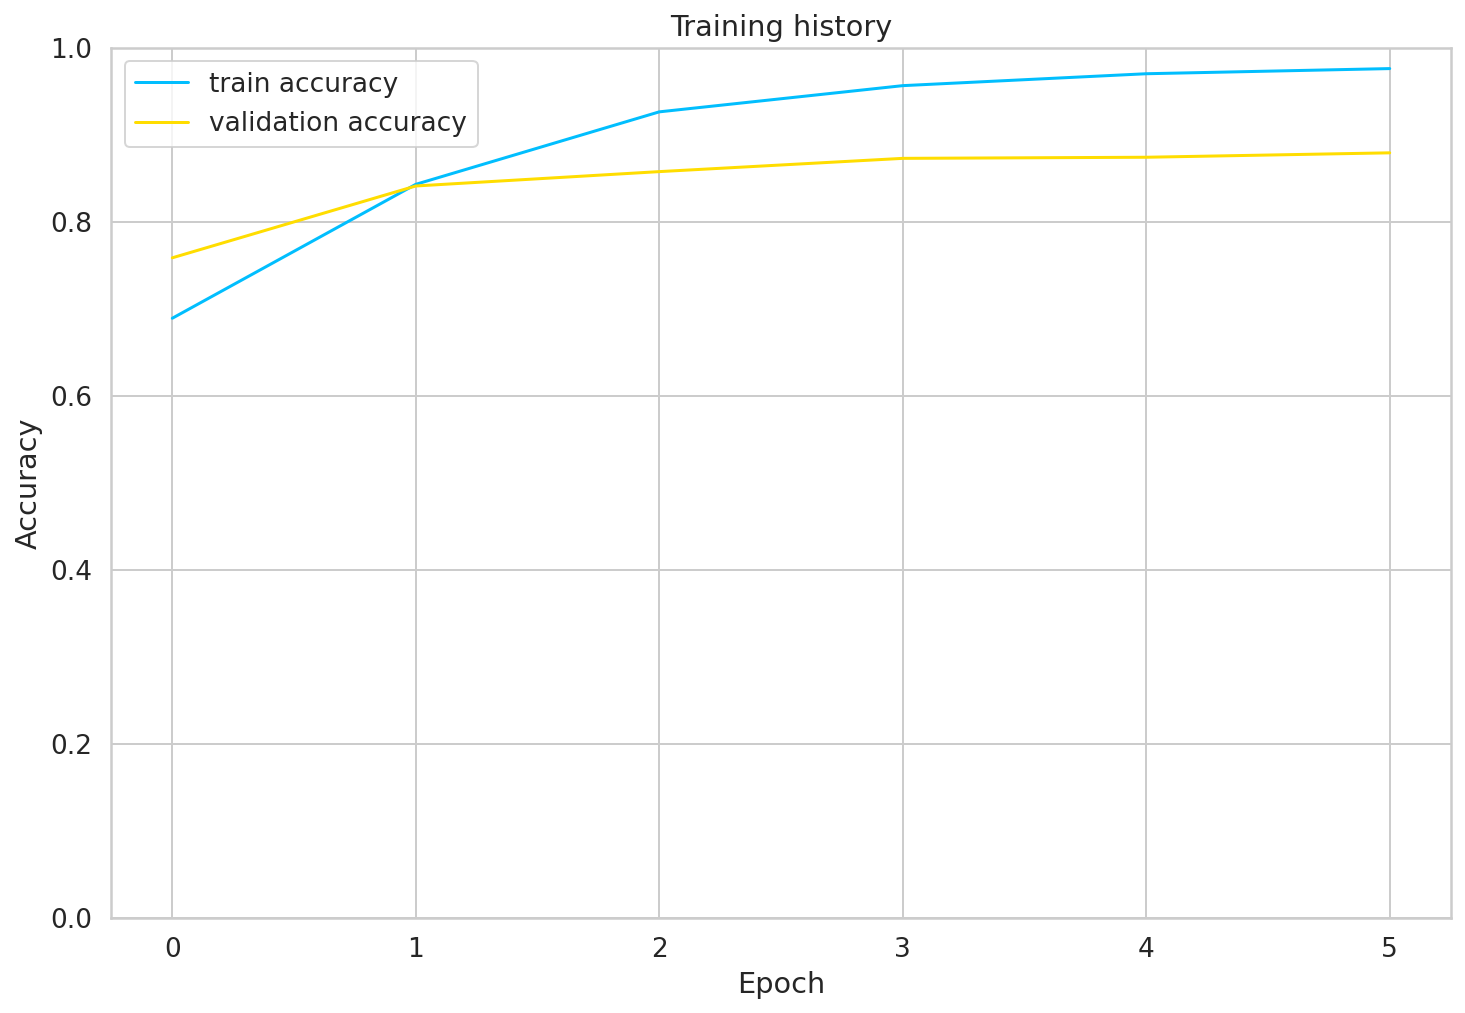

In [31]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [38]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/best_model_state.pt')) # , map_location=torch.device('cpu')
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# 4. Model Evaluation

Calculate the accuracy on the test data.

In [39]:
test_acc, _ = eval_model(model,
                         test_data_loader,
                         loss_fn,
                         device,
                         len(df_test))

test_acc
#test_acc.item()

tensor(0.8820, device='cuda:0', dtype=torch.float64)

In [33]:
def get_predictions(model, data_loader):
    model = model.eval()
  
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask)
            
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    
    return review_texts, predictions, prediction_probs, real_values

In [34]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

print(classification_report(y_test, y_pred, target_names = class_names))

              precision    recall  f1-score   support

    negative       0.92      0.87      0.90       245
     neutral       0.81      0.86      0.84       254
    positive       0.92      0.91      0.91       289

    accuracy                           0.88       788
   macro avg       0.88      0.88      0.88       788
weighted avg       0.88      0.88      0.88       788



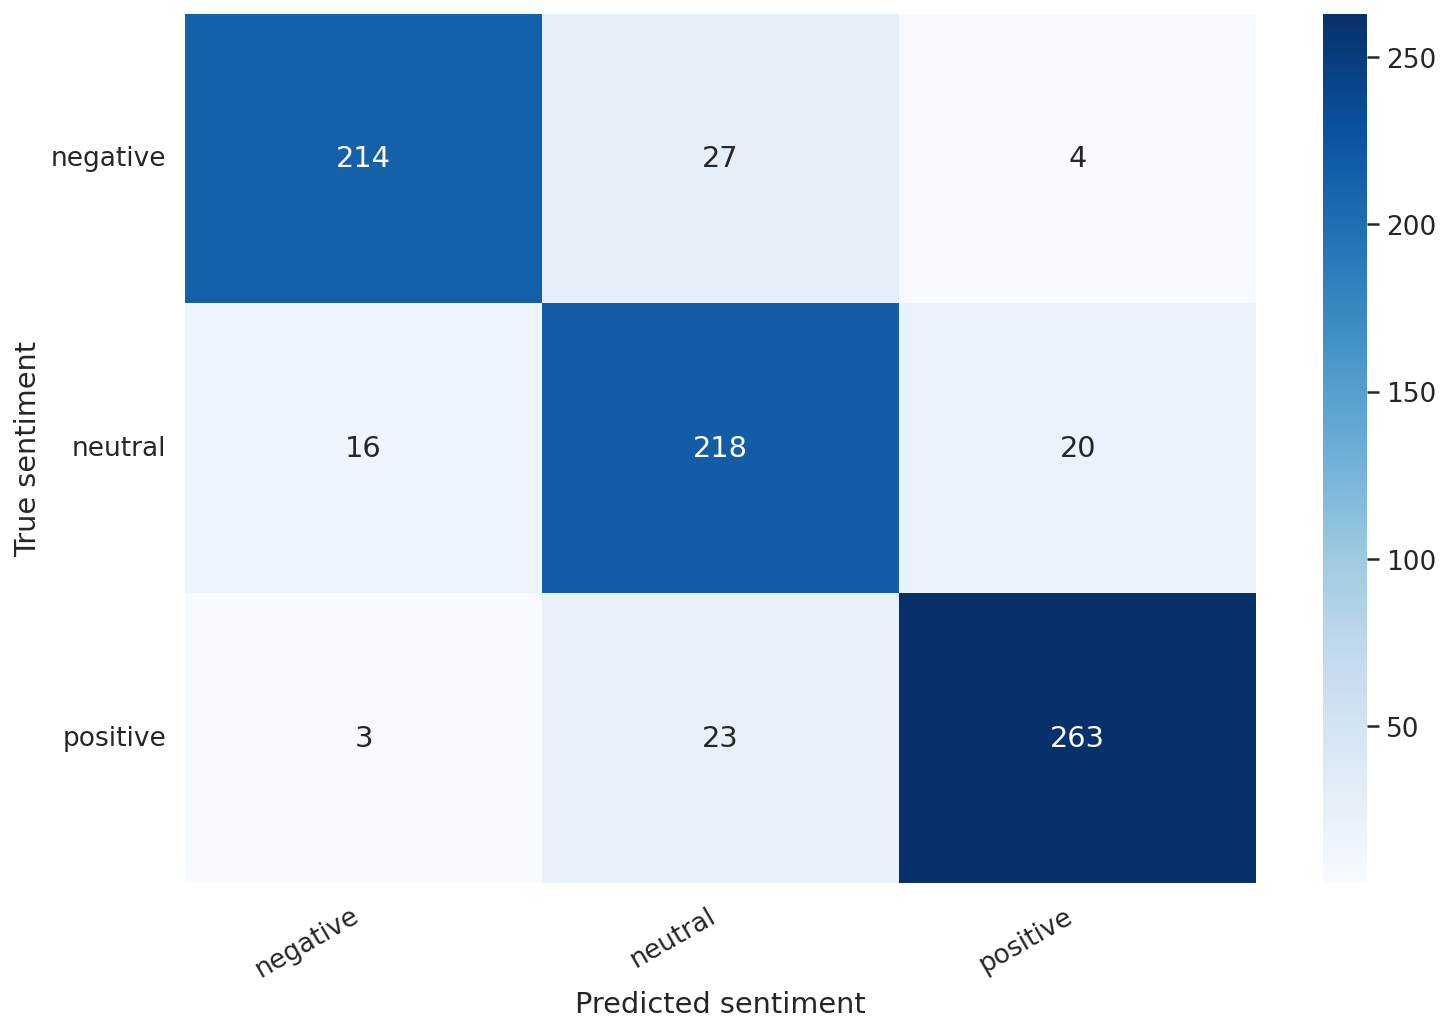

In [35]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

# Test on a single review

In [36]:
idx = 42

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({'class_names': class_names,
                        'values': y_pred_probs[idx]})

print("\n".join(wrap(review_text)))
print()
print('True sentiment: ', class_names[true_sentiment])

I would give this app 5 stars but I am beyond frustrated with how slow
it is to open. I pay the subscription for premium, and I love all the
options in the app. But it literally takes 5 to 10 minutes for the app
to open, unless there is a notification in my notification bar that I
can open the app with. This would be annoying even with a free app,
but to pay for a slow app that takes ages to open is ridiculous. In
the 2 or 3 years that I've used it this has never been fixed with any
upgrade.

True sentiment:  neutral


In [37]:
review_text = "I love Bert! It is awesome!"

encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  truncation = True,
  padding = 'max_length',
  return_attention_mask=True,
  return_tensors='pt',
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print('Review text: ', review_text)
print('Sentiment  : ', class_names[prediction])

Review text:  I love Bert! It is awesome!
Sentiment  :  positive
